In [1]:
from __future__ import print_function
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns
import gc

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score

import keras
from keras import regularizers
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add,PReLU, LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Reshape, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import tensorflow as tf
import horovod.keras as hvd

Using TensorFlow backend.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [2]:
# reduce memory
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [3]:
train = reduce_mem_usage(pd.read_csv('../input/train.csv'))
test = reduce_mem_usage(pd.read_csv('../input/test.csv'))

Memory usage after optimization is: 78.01 MB
Decreased by 74.7%
Memory usage after optimization is: 77.82 MB
Decreased by 74.6%


In [4]:
features = [f for f in train if f not in ['ID_code','target']]

In [5]:
df_original = pd.concat([train, test],axis=0,sort=False)
df = df_original[features]
target = df_original['target'].values

In [6]:
#for feature in features:
#    df['mean_'+feature] = (train[feature].mean()-train[feature])
#    df['z_'+feature] = (train[feature] - train[feature].mean())/train[feature].std(ddof=0)
#    df['sq_'+feature] = (train[feature])**2
#    df['sqrt_'+feature] = np.abs(train[feature])**(1/2)

In [7]:
for df in [df]:
#####Handling Missing Values#####     
    for i in range(len(df.columns)):
        df.iloc[:,i] = (df.iloc[:,i]).fillna(-1)

/home/wopr/.local/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [ ]:
df.isnull().values.any()

In [8]:
from scipy.special import erfinv

trafo_columns = [c for c in df.columns if len(df[c].unique()) != 2]
for col in trafo_columns:
    values = sorted(set(df[col]))
    # Because erfinv(1) is inf, we shrink the range into (-0.9, 0.9)
    f = pd.Series(np.linspace(-0.9, 0.9, len(values)), index=values)
    f = np.sqrt(2) * erfinv(f)
    f -= f.mean()
    df[col] = df[col].map(f)

/home/wopr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
pca.fit(df[trafo_columns])

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [10]:
df['target'] = df_original['target']
df.head(5)

/home/wopr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,target
0,0.276234,-1.248264,0.492790,0.178309,0.301589,-1.103686,0.089022,0.470353,-1.241425,-0.489018,...,0.264992,1.095784,0.690561,0.287438,-1.189143,1.255593,0.127525,-0.142190,-0.439702,0.0
1,0.544823,-1.053062,0.787904,0.232411,0.491863,1.179872,0.271400,0.289916,1.054877,0.565805,...,0.720530,1.007539,1.377199,-0.075167,1.229373,1.270814,0.197394,0.609579,0.682261,0.0
2,0.245349,-0.890334,0.516770,0.739213,0.126346,-1.097304,0.821339,0.021898,-1.241094,-0.389013,...,0.892009,0.833005,0.689442,0.625478,1.481717,-1.262358,0.036855,0.174366,0.313988,0.0
3,0.496957,-0.824797,0.111059,0.583860,0.542499,-0.621498,0.354577,0.070753,-1.325206,0.606487,...,0.355110,0.545014,0.639970,0.805761,-0.897988,-0.942853,0.707354,0.571748,-0.994165,0.0
4,0.368229,-0.703462,0.632252,0.469332,0.472988,0.818812,0.391812,0.527034,1.381489,0.387166,...,0.871307,-0.407311,1.296442,-0.517185,-0.965731,0.975661,0.424890,0.574743,-0.988783,0.0


In [11]:
df = reduce_mem_usage(df)

/home/wopr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Memory usage after optimization is: 156.40 MB
Decreased by 74.6%


In [12]:
train = df[df['target'].notnull()]
target = train['target']
train = pd.DataFrame(pca.transform(train[trafo_columns]))
test = df[df['target'].isnull()]
test = pd.DataFrame(pca.transform(test[trafo_columns]))
train.shape

trafo_columns = [c for c in train.columns if len(train[c].unique()) != 2]
train['target'] = target.values

/home/wopr/.local/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/home/wopr/.local/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


In [31]:
from keras.activations import elu
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler
from keras import backend as K
from imblearn.keras import balanced_batch_generator
from imblearn.under_sampling import NearMiss, RandomUnderSampler, CondensedNearestNeighbour, AllKNN
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler
# Horovod: adjust learning rate based on number of GPUs.
opt = keras.optimizers.SGD(lr=0.00001, decay=0.96, momentum=0.001, nesterov=True)
# Horovod: add Horovod Distributed Optimizer.
opt = hvd.DistributedOptimizer(opt)


nb_folds = 3
nb_epoch = 2
batch_size = 240
encoding_dim =1000
hidden_dim = int(encoding_dim * 10) #i.e. 7
sgd = SGD(lr=0.001, momentum=0.001, decay=0.96)
folds = StratifiedKFold(n_splits=nb_folds, shuffle=True, random_state=420)
#folds = KFold(n_splits = nb_folds, random_state = 338, shuffle = True)
train_auto = np.zeros(train[trafo_columns].shape)
test_auto = np.zeros(test[trafo_columns].shape)
predictions = np.zeros(len(train))
label_cols = ["target"]
y_split = train[label_cols].values

cp = ModelCheckpoint(filepath="autoencoder_0.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

es= EarlyStopping(monitor='val_loss',
                  min_delta=0,
                  patience=50,
                  verbose=1, mode='auto')

for fold_, (trn_idx, val_idx) in enumerate(folds.split(y_split[:,0], y_split[:,0])):
    print("fold {}".format(fold_))
#for fold_, (trn_idx, val_idx) in enumerate(folds.split(train)):
#    print("fold {}".format(fold_))

    trn_data, train_y = train[trafo_columns].iloc[trn_idx], train['target'].iloc[trn_idx]
    val_data, valid_y = train[trafo_columns].iloc[val_idx], train['target'].iloc[val_idx]

    input_dim = trn_data.shape[1] #num of columns, 30
    input_layer = Input(shape=(input_dim, ))
    
    # Q(z|X) -- encoder
    h_q = Dense(encoding_dim, activation='relu')(input_layer)
    mu = Dense(hidden_dim, activation='linear')(h_q)
    log_sigma = Dense(hidden_dim, activation='linear')(h_q)
    
    def sample_z(args):
        mu, log_sigma = args
        batch = K.shape(mu)[0]
        dim = K.int_shape(mu)[1]
        eps = K.random_normal(shape=(batch, dim))
        return mu + K.exp(0.5 * log_sigma) * eps

    # Sample z ~ Q(z|X)
    z = Lambda(sample_z)([mu, log_sigma])
    
    # P(X|z) -- decoder
    decoder_hidden = Dense(hidden_dim, activation='relu')
    decoder_out = Dense(input_dim, activation='softmax')
    h_p = decoder_hidden(z)
    outputs = decoder_out(h_p)
    
    # Overall VAE model, for reconstruction and training
    vae = Model(input_layer, outputs)
    
    # Encoder model, to encode input into latent variable
    # We use the mean as the output as it is the center point, the representative of the gaussian
    encoder = Model(input_layer, mu)

    # Generator model, generate new data given latent variable z
    d_in = Input(shape=(hidden_dim,))
    d_h = decoder_hidden(d_in)
    d_out = decoder_out(d_h)
    decoder = Model(d_in, d_out)
    
    def vae_loss(y_true, y_pred):
        """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
        # E[log P(X|z)]
        recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
        # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
        kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)
        return recon + kl
    
    vae.compile(optimizer='sgd', loss=vae_loss, metrics=['acc'])
    
    def add_noise(series, noise_level):
        return series * (1 + noise_level * np.random.randn(series.shape[1]))
    
    trn_data = add_noise(trn_data, 0.05)
#    val_data = add_noise(val_data, 0.07)
    

    training_generator, steps_per_epoch = balanced_batch_generator(trn_data, train_y, sampler=RandomOverSampler(),
                                                batch_size=batch_size, random_state=42)

    callback_history = vae.fit_generator(training_generator,epochs=nb_epoch,
                       validation_data=[val_data, val_data], 
                       steps_per_epoch=steps_per_epoch, verbose=1,
                       callbacks=[cp, tb, es])

    train_auto[val_idx] += vae.predict(train.iloc[val_idx][trafo_columns], verbose=1)
    test_auto += vae.predict(test[trafo_columns], verbose=1)

    mse = vae.predict(train[trafo_columns] / folds.n_splits, verbose=1)
    predictions += np.mean(np.power(train[trafo_columns] - mse, 2), axis=1)

train_auto = pd.DataFrame(train_auto / folds.n_splits)
test_auto = pd.DataFrame(test_auto / folds.n_splits)
error_df = pd.DataFrame({'Reconstruction_error': predictions,
                        'True_class': train['target']})
error_df.describe()

fold 0
Epoch 1/2
999/999 [==============================] - 61s 61ms/step - loss: 800.1196 - acc: 0.0025 - val_loss: 253.6297 - val_acc: 0.0085
Epoch 2/2
200000/200000 [==============================] - 22s 109us/step
fold 1
Epoch 1/2
999/999 [==============================] - 65s 65ms/step - loss: 800.1594 - acc: 0.0639 - val_loss: 253.2430 - val_acc: 0.0082
Epoch 2/2
200000/200000 [==============================] - 22s 111us/step
fold 2
Epoch 1/2
999/999 [==============================] - 65s 65ms/step - loss: 800.1802 - acc: 0.0012 - val_loss: 253.3920 - val_acc: 0.0076
Epoch 2/2
200000/200000 [==============================] - 22s 111us/step


,Reconstruction_error,True_class
count,200000.000000,200000.0
mean,1.956053,0.0
std,0.231028,0.0
min,1.133084,0.0
25%,1.796056,0.0
50%,1.945483,0.0
75%,2.105687,0.0
max,3.216720,1.0


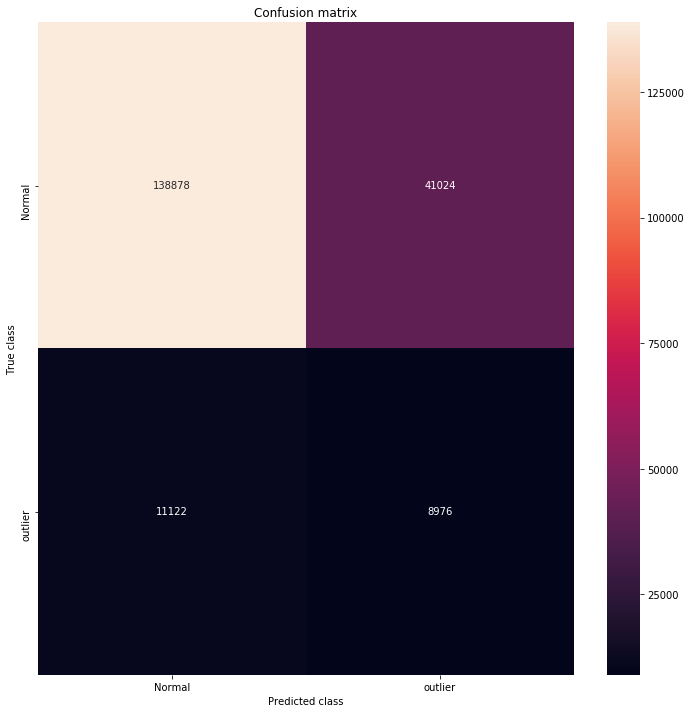

In [32]:
####Edit thiS!!!!!####
from sklearn.metrics import confusion_matrix

LABELS = ["Normal","outlier"]
threshold_fixed = 2.105687
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(train['target'], pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [33]:
train_id = df_original[df_original['target'].notnull()]
test_id = df_original[df_original['target'].isnull()]

train_auto['target'] = target
train_auto['id'] = train_id['ID_code']
test_auto['id'] = test_id['ID_code']

In [34]:
train_auto.head(5)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,target,id
0,0.002227,0.001164,0.005570,0.000704,0.000640,0.000461,0.001963,0.000730,0.004098,0.003401,...,0.000574,0.004162,0.000409,0.001437,0.002250,0.003215,0.001601,0.004311,0.0,train_0
1,0.002907,0.003055,0.007179,0.001255,0.001825,0.001582,0.002146,0.002056,0.001749,0.002990,...,0.000367,0.003391,0.001873,0.002375,0.006924,0.001022,0.018457,0.002395,0.0,train_1
2,0.003821,0.003746,0.002011,0.003343,0.010168,0.000604,0.000611,0.003293,0.002589,0.003075,...,0.006187,0.003842,0.001869,0.020693,0.002273,0.001177,0.002150,0.011132,0.0,train_2
3,0.003260,0.000733,0.003551,0.000739,0.002255,0.002811,0.000354,0.001479,0.002153,0.000941,...,0.000910,0.001169,0.000805,0.000495,0.001376,0.003231,0.000609,0.000326,0.0,train_3
4,0.013083,0.000722,0.020825,0.011910,0.001083,0.001033,0.002588,0.001583,0.001805,0.000956,...,0.008724,0.002281,0.008114,0.001016,0.000351,0.001530,0.009704,0.001803,0.0,train_4


In [ ]:
%whos DataFrame

In [ ]:
lst = [trn_data, val_data, df_original, train]
del trn_data, val_data, df_original, train
del lst     # memory is released

In [ ]:
#df_original['auto_mse_lvl_0'] = error_df.Reconstruction_error.values
#bcvdf_original['classlvl_0'] = [1 if e > threshold_fixed else 0 for e in df_original.auto_mse_lvl_0.values]
#df_original.head(5)bcv

In [35]:
#df_original.to_csv("df_original.csv", index=False)
train_auto.to_csv("auto_model_reconstructions/train_auto_0.csv", index=False)
test_auto.to_csv("auto_model_reconstructions/test_auto_0.csv", index=False)